# Visualization of the trained model

In [43]:
import sys
from utils.utils import *
from utils.visualizations import *
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T

## Loading the model

**Important**: Change the following paths to match the location where your data is stored.

In [44]:
DATA_LOCATION = '../data'
model_path = DATA_LOCATION + '/logs/EncoderDecorder_model.pth'
device = 'cpu' # or 'cuda:0'

In [45]:
model = load_ED_model(model_path, device)

## Visualizing the saved image and caption for a certain epoch

In [46]:
caption = joblib.load(DATA_LOCATION + '/logs/Captions/caps_epoch_25.joblib')
image = joblib.load(DATA_LOCATION + '/logs/Images/img_epoch_25.joblib')

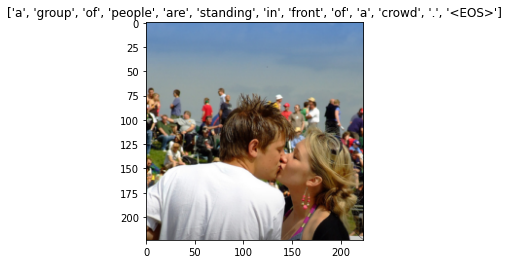

In [47]:
show_image(image, caption)

## Feeding the model other images from the test dataset

First we have to load the dataset.

In [48]:
transforms = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

config = dict(
    root_dir=DATA_LOCATION+"/Images",
    captions_file=DATA_LOCATION+"/captions.txt",
    device=device,
    encoder='ResNet50',
    transforms=transforms,
    embed_size=300,
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512,
    epochs=25,
    learning_rate=3e-4,
    batch_size=int(256),
    DATA_LOCATION=DATA_LOCATION,
    train_size=0.8,
    save=True
)

def make_dataset(config):
    dataset = joblib.load(config['DATA_LOCATION'] + "/processed_dataset.joblib")
    dataset.spacy_eng = spacy.load("en_core_web_sm")
    return dataset

def make_dataloaders(config, dataset, num_workers):
    train_dataset, test_dataset = flickr_train_test_split(dataset, config['train_size'])

    train_loader = get_data_loader(train_dataset, dataset, batch_size=config['batch_size'], num_workers=num_workers)
    test_loader = get_data_loader(test_dataset, dataset, batch_size = 5, num_workers=num_workers)

    return train_loader, test_loader

In [49]:
dataset = make_dataset(config)
vocab = dataset.vocab
train_loader, test_loader = make_dataloaders(config, dataset, 1)
model.decoder.device = 'cpu'

Now we can show the images with the predicted captions and the real captions.

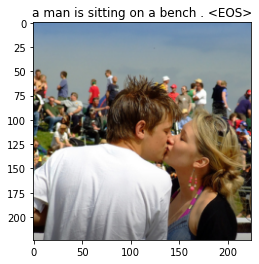

REAL CAPTIONS:

['a', 'young', 'couple', 'kiss', 'while', 'a', 'crowd', '<UNK>', 'in', 'the', 'background', 'on', 'a', 'sunny', 'day', '.', '<EOS>']
['two', 'people', 'kiss', 'near', 'a', 'crowd', '.', '<EOS>']
['a', 'man', 'is', 'kissing', 'a', 'woman', '.', '<EOS>']
['a', 'man', 'and', 'a', 'woman', 'kissing', '.', '<EOS>']
['a', 'man', 'and', 'woman', 'kissing', 'in', 'front', 'of', 'a', 'crowd', 'of', 'people', '.', '<EOS>']


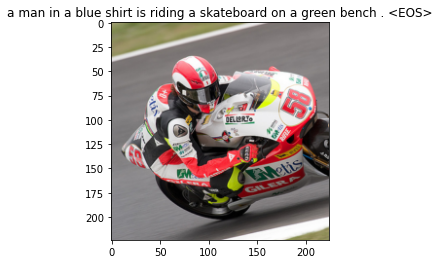

REAL CAPTIONS:

['a', 'man', 'racing', 'on', 'a', 'motorbike', '<EOS>']
['a', 'motorcycle', 'rider', 'drives', 'fast', 'around', 'a', 'curve', 'on', 'a', 'track', '.', '<EOS>']
['a', 'person', 'wearing', 'a', 'red', 'and', 'white', 'uniform', 'is', 'racing', 'a', 'motorcycle', 'with', 'the', 'number', '<UNK>', 'on', 'it', '.', '<EOS>']
['a', 'red', 'and', 'white', 'motorcycle', 'is', 'being', 'ridden', 'around', 'a', 'bend', 'on', 'a', 'racetrack', '.', '<EOS>']
['red', 'and', 'white', 'motorbike', 'number', '<UNK>', 'races', 'around', 'the', 'track', '.', '<EOS>']


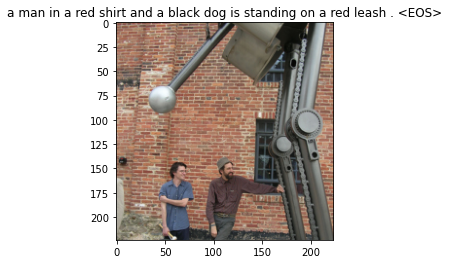

REAL CAPTIONS:

['two', 'men', 'standing', 'near', 'a', 'metal', 'structure', 'in', 'from', 'of', 'a', 'brick', 'wall', '.', '<EOS>']
['two', 'men', 'standing', 'at', 'the', 'feet', 'of', 'a', 'large', 'sculpture', '.', '<EOS>']
['two', 'men', 'are', 'standing', 'under', 'what', 'looks', 'to', 'be', 'a', 'giant', 'robot', '.', '<EOS>']
['a', 'man', 'leans', 'against', 'a', 'large', 'robot', '.', '<EOS>']
['two', 'men', 'are', 'standing', 'under', 'a', 'large', 'work', 'of', 'art', 'by', 'a', 'brick', 'building', '.', '<EOS>']


In [50]:
# Number of images to show
num_show = 3

# Showing the images
test_loader_showing = deepcopy(test_loader)
with torch.no_grad():
    dataiter = iter(test_loader_showing)
    for i in range(num_show):    
            img, real_captions = next(dataiter)
            features = model.encoder(img[0:1].to(device))
            caps, alphas = model.decoder.generate_caption(features, vocab=vocab)
            caption = ' '.join(caps)
            show_image(img[2], caption)
            print("REAL CAPTIONS:\n")
            for i in range(len(real_captions)):
                print(dataset.vocab.get_caption(real_captions[i].tolist()))

## Feeding the model a custom image

In [51]:
# Path to the custom image
img_location = DATA_LOCATION + '/Custom/us3.png' 

# Transforming the image to the correct format
img = Image.open(img_location)
img = img.convert("RGB")
img = transforms(img)
img = img.unsqueeze(0)

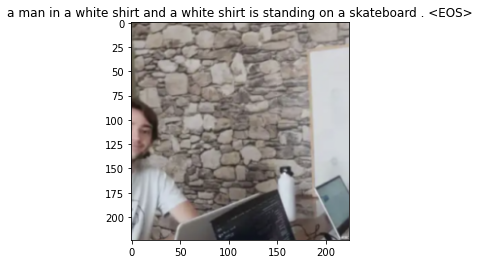

In [52]:
# Feeding the model the image
features = model.encoder(img.to(device))
caps, alphas = model.decoder.generate_caption(features, vocab=vocab)

# Showing the caption and the image
caption = ' '.join(caps)
show_image(img[0], caption)

## Visualizing the attention for a certain image

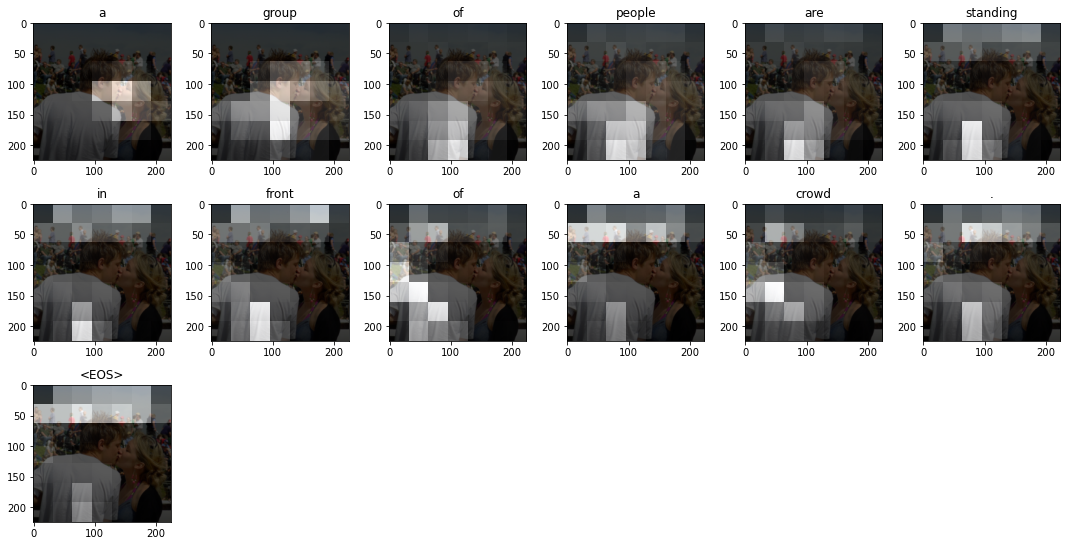

In [53]:
test_loader_showing = deepcopy(test_loader)
dataiter = iter(test_loader_showing)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(model, img.unsqueeze(0), vocab, device)

plot_attention(img1, caps, alphas)

## Seeing the output of the Encoder for an image

In [54]:
# Getting an image from the raw dataset
path = DATA_LOCATION + "/Images" 
files = [f for f in os.listdir(path) if f.endswith('.jpg')]
file= files[2]
img = Image.open(os.path.join(path, file))

In [55]:
# Transforming the image to the correct format
img = img.convert("RGB")
img = transforms(img)
img = img.unsqueeze(0)

In [56]:
# Passing the image through the encoder
features = model.encoder(img.to(device))

In [57]:
features.shape

torch.Size([1, 49, 2048])

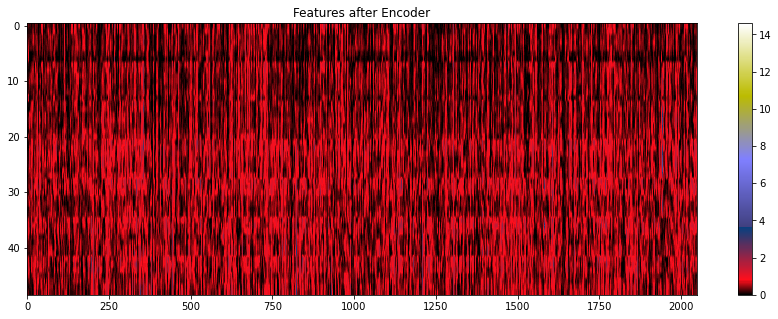

In [58]:
plt.figure(figsize=(15,5))
plt.imshow(features[0], cmap='gist_stern', aspect='auto')  # Display the tensor as an image
plt.colorbar()
plt.title("Features after Encoder")
plt.show()

## Seeing how the embedding works inside the Decoder

In [59]:
# Visualizing the captions for the 3rd image in the train dataset
i = 2
captions = list(dataset.captions[0 + i*5 : 5 + i*5])
captions

['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails painting outside in the grass .']

In [60]:
# Getting the processed captions for the 3rd image in the train dataset
test_train_loader = deepcopy(train_loader)
_, caption = next(iter(train_loader))
captions = [caption[i] for i in range(10,15)]
captions = torch.stack(captions); captions

tensor([[   1,    4,    9,    7,  114,    8, 1447,   77,    8,   23,   11,    4,
          325,  643,   12,  104,  229,    8,    4, 1301,    5,    2,    0,    0,
            0,    0],
        [   1,    4,    9,    7,   17,   46,    8,   23,   11,    4,   53,  325,
          643,    5,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   1,    4,   85,    7,    8,   10,   22,   92,   12,    3,    8,   23,
           11,    4,   21, 2306,   12,    4,  643,   13,   64,    5,    2,    0,
            0,    0],
        [   1,  204,   17,    4,    7,   12,   91,   46,    8,   23,   11,    4,
          643,  176,    5,    2,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   1,   61,    7,   12,   91,  176,   70,    8,   10,   22,    5,    2,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0]])

In [61]:
# Generating an intance of the embedding class from torch
vocab_size = len(dataset.vocab)
embed_size = 300
embdedding = nn.Embedding(vocab_size, embed_size)

In [62]:
# Embedding the 5 captions
embedded = embdedding(captions)

In [63]:
# First caption embedded
embedded[0]

tensor([[ 1.2922, -1.0861, -0.5330,  ...,  1.7224, -1.4617, -0.2545],
        [-1.9324,  0.9966, -0.1060,  ...,  1.4908, -1.4338, -0.8337],
        [ 0.0264, -1.2520,  0.4302,  ..., -0.6432,  1.1984, -1.0768],
        ...,
        [ 0.3999,  0.0777,  0.7061,  ...,  0.4976, -0.2368, -0.7189],
        [ 0.3999,  0.0777,  0.7061,  ...,  0.4976, -0.2368, -0.7189],
        [ 0.3999,  0.0777,  0.7061,  ...,  0.4976, -0.2368, -0.7189]],
       grad_fn=<SelectBackward0>)

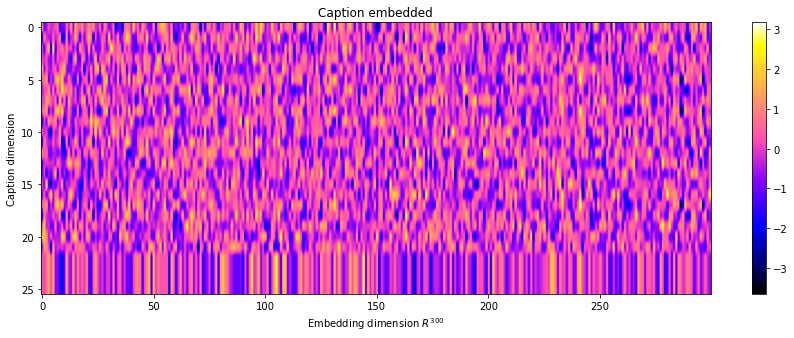

Caption embedded: tensor([   1,    4,    9,    7,  114,    8, 1447,   77,    8,   23,   11,    4,
         325,  643,   12,  104,  229,    8,    4, 1301,    5,    2,    0,    0,
           0,    0])


In [64]:
plt.figure(figsize=(15,5))
plt.imshow(embedded[0].detach().numpy(), cmap='gnuplot2', aspect='auto')  # Display the tensor as an image
plt.colorbar()
plt.title("Caption embedded")
plt.ylabel("Caption dimension")
plt.xlabel("Embedding dimension $R^{300}$")
plt.show()
print("Caption embedded:", captions[0])

## Visualizing the attention weights for a certain caption

In [65]:
caps, alphas = model.decoder.generate_caption(features, vocab=vocab)

In [66]:
alpha = torch.tensor(alphas[0])

In [67]:
alpha.shape # the first dimension is the number of words of the caption

torch.Size([1, 49])

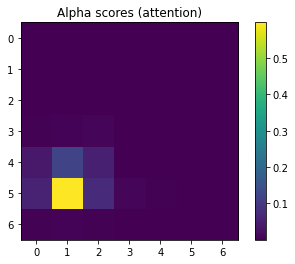

In [68]:
alpha_values = np.array(alpha[0].tolist())
matrix = alpha_values.reshape((7, 7))
plt.imshow(matrix, cmap='viridis')  # You can choose a different colormap if desired
plt.colorbar()
plt.title('Alpha scores (attention)')
plt.show()

In [69]:
features.shape

torch.Size([1, 49, 2048])

In [70]:
attention_weights = features * alpha.unsqueeze(2)
attention_weights = attention_weights.sum(dim=1)

In [71]:
len(attention_weights[0])

2048

In [72]:
attention_weights

tensor([[0.6859, 0.4997, 2.0985,  ..., 1.3035, 0.4085, 0.0727]])

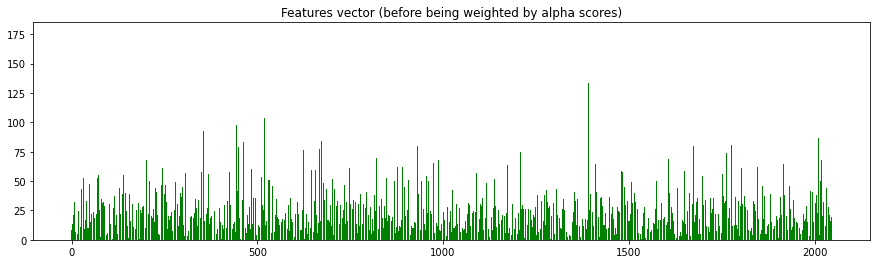

In [73]:
plt.figure(figsize=(15,4))
plt.bar(range(len(features.sum(dim=1)[0])), features.sum(dim=1)[0], color='green')
plt.title('Features vector (before being weighted by alpha scores)') # Dictates where to focus the attention
plt.show()

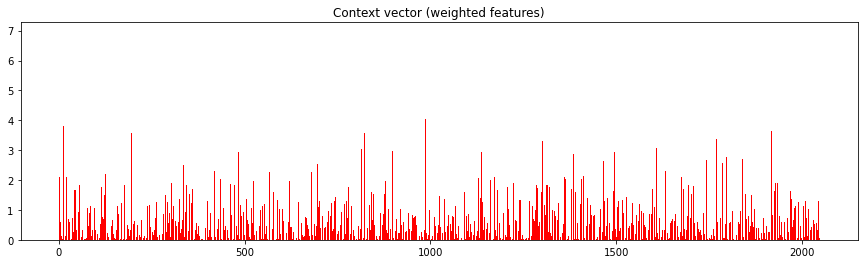

In [74]:
plt.figure(figsize=(15,4))
plt.bar(range(len(attention_weights[0])), attention_weights[0], color='red')
plt.title('Context vector (weighted features)') # Dictates where to focus the attention
plt.show()